In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd 
import os
import torch
from torch import optim as opt
from torch import nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset,DataLoader
from sklearn import preprocessing 
from torchvision import transforms
import imageio as iio
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt


In [2]:
bs = 48
num_epochs = 100

In [3]:
names = ['Amin','Farzad','Maziar','Mehrdad','Sina','Soheil','Vahid']
name_file = {name:[] for name in names}

for dirname, _, filenames in os.walk('/kaggle/input/arabicpersian-handwritten-cities-for-postal-apps/scan splited/scan splited'):
    filenames = sorted(filenames) # i want it to be on the same order
    for filename in filenames:
        name = dirname[89:]
        name_file[name].append(os.path.join(dirname, filename))

# I just want to take a subset of the dataset

In [4]:
alphabit = "ابتثجحخدذرزسشصضطظعغفقكلمنهويئ"
num_output = len(alphabit)
alphabit = [a for a in alphabit]
print(num_output)

29


In [5]:
def pad_words(targets):
    """
    Padding words to make all of them on the same size
    """
    targets_new = []
    for target in targets:
        pad = 6-len(target)
        targets_new.append(np.concatenate((np.ones(pad),target),axis=0).astype(np.longlong))
        
        
    return targets_new

In [6]:
words = (" خيابان ميدان نمين ديلم مهران كاشان برحوار نائين البرز يزد تبريز سيريك") # only these words will be considerd
words = words*4 # four persons wrote these words
words = words.split(' ')
words.__delitem__(0) # first element is just empty


imgs = []
for name,files in name_file.items():
    if  name.__eq__('Maziar') or name.__eq__('Mehrdad') or name.__eq__('Sina'):
        continue
    for i,file in enumerate(files):
        if i == 12:
            break
        imgs.append(file)
    

targets = [[w for w in word] for word in words]
lbl_enc = preprocessing.LabelEncoder()
lbl_enc.fit(alphabit)
targets_enc = [lbl_enc.transform(word)+2 for word in targets]
targets_enc = pad_words(targets_enc)
dataset = {'imgs':imgs, "labels":targets_enc}
df = pd.DataFrame(dataset)


# Dataset and DataLoader

In [7]:
class Mydataset(Dataset):
    
    def __init__(self,df,trans=None):
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        x = Image.open(self.df['imgs'][idx]).convert('RGB')
        if trans:
            x = trans(x)
        y = self.df['labels'][idx] # +1 i have already add one in the above cell 
        return (x,y)
    
    

In [8]:
# std = torch.tensor([0.0603, 0.0606, 0.0347])
# mean = torch.tensor([[0.8753, 0.8924, 0.9244]])


In [9]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(20,80)),
    transforms.Normalize(mean=(0.8753,0.8924,0.9244),std=(0.0603,0.0606,0.0347))
                           ])
all_imgs = []
dataset = Mydataset(df,trans)

    

train_loader = DataLoader(dataset,batch_size=bs)

    

In [10]:
test =  torch.tensor([ [ [1,2,3],[5,6,4] ],[[1,1,1],[2,2,2]] ])
aaa = torch.argmax(test,dim=1)  
# lbl_enc.inverse_transform
a = [ t.shape for t in aaa]
aaa.shape

lbl_enc.inverse_transform(np.array([6]))

array(['ح'], dtype='<U1')

In [11]:

def decode_pred(y_pred,targets):
    """
    applying inverse_transform to convert numbers to characters
    """    
    # first we need to remove blanks(0) and padding (1)
    targets_filtered = [target[(target!=0) & (target!=1)]-2 for target in targets] 
    y_pred = torch.argmax(y_pred,dim=2).permute(1,0) 
    y_pred_filtered = [y[(y!=0) & (y!=1)]-2 for y in y_pred]

    targets_dec = [lbl_enc.inverse_transform(tf) for tf in targets_filtered ]
    y_pred_dec = [lbl_enc.inverse_transform(yf) for yf in y_pred_filtered ]
    results = {
        'targets_filtered':targets_filtered,
        'y_pred_filtered':y_pred_filtered,
        'targets_dec':targets_dec,
        'y_pred_dec':y_pred_dec
              }
    return results
    


# Model

In [12]:
feature_map = torch.tensor([48, 84, 5, 20]) # bs,c,h,w

class MyCNN(nn.Module):
    
    def __init__(self):
        super(MyCNN,self).__init__()
        self.conv1 = nn.Conv2d(3,12,3,2,padding=1)
        self.conv2 = nn.Conv2d(12,36,3,2,padding=1)
        self.conv3 = nn.Conv2d(36,84,3,1,padding=1)
        
    def forward(self,x):
        x = self.conv1(F.relu(x))
#         print(x.shape)
        x = self.conv2(F.relu(x))
#         print(x.shape)
        x = self.conv3(F.relu(x))
        return x
    
class MyRNN(nn.Module):
    
    def __init__(self,input_size,hidden_size,num_layers,bi):
        super(MyRNN,self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers        
        self.bi = bi
        self.D = 2 if self.bi else 1 
        self.gru = nn.GRU(input_size,hidden_size,num_layers,bidirectional=bi,batch_first=True)
        self.linear1 = nn.Linear(self.D*hidden_size,self.D*hidden_size)
        self.linear2 = nn.Linear(self.D*hidden_size,num_output+2) # +2 for the blank ctc and padding
        
        
    def forward(self,x): 
        # x : (bs,T,features)
        h0 = torch.zeros(self.D*self.num_layers,x.size(0),self.hidden_size)
        out,hn = self.gru(x,h0)
        out = self.linear1(F.relu(out))
        out = self.linear2(out)
        out = F.log_softmax(out,dim=2)
        out = out.permute(1,0,2)
        return out
        
        
# class denseLayer(nn.Module):
#     def __init__
    
    
class MyModel(nn.Module):
    
    def __init__(self,hidden_size,num_layers,bi):
        super(MyModel,self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers  
        self.bi = bi
        self.cnn = MyCNN()
        self.rnn = MyRNN(feature_map[1]*feature_map[2],hidden_size,num_layers,bi)
        
    def forward(self,x):
        x = self.cnn(x)
#         print(x.shape) # --> (bs,c,h,w)
        x = x.view(-1,x.shape[3],x.shape[2]*x.shape[1]) # --> (bs,w,h*c)
        
        # i will assume that num of channels is the time_stamps 
        # i've changed my mind :) , w = time_stamps
        # for rnn , we need (time_stamps,bs,featuers)
        
#         x = x.permute(1,0,2)  ### ????? BATCH_FIRST = TRUE
#         print(x.shape)
        x = self.rnn(x)
        
        return x



# Training

In [13]:
loss_fn =  nn.CTCLoss(blank=0)
model = MyModel(300,2,True)
lr = 1e-3
optim = opt.Adam(model.parameters(),lr=lr) 

batch = next(iter(train_loader))       
train_loss = []
for epoch in range (500):
    losses = 0
    for batch in train_loader:
        x,y = batch[0],batch[1]
        out = model(batch[0])
        input_lengths = torch.full(size=(x.shape[0],), fill_value=out.shape[0], dtype=torch.long)
        target_lengths = torch.full(size=(x.shape[0],), fill_value=batch[1].size(1), dtype=torch.long)
        optim.zero_grad()
        loss = loss_fn(out,batch[1],input_lengths,target_lengths)
        loss.backward()
        optim.step()
        losses += loss.item()
    print(epoch)    
    train_loss.append(losses/len(train_loader))    


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

# Evaluating

In [14]:
decode_pred(out,batch[1])

{'targets_filtered': [tensor([ 7, 28,  1,  2,  1, 25]),
  tensor([24, 28,  8,  1, 25]),
  tensor([25, 24, 28, 25]),
  tensor([ 8, 28, 23, 24]),
  tensor([24, 26, 10,  1, 25]),
  tensor([22,  1, 13,  1, 25]),
  tensor([ 2, 10,  6, 27,  1, 10]),
  tensor([25,  1,  0, 28, 25]),
  tensor([ 1, 23,  2, 10, 11]),
  tensor([28, 11,  8]),
  tensor([ 3,  2, 10, 28, 11]),
  tensor([12, 28, 10, 28, 22]),
  tensor([ 7, 28,  1,  2,  1, 25]),
  tensor([24, 28,  8,  1, 25]),
  tensor([25, 24, 28, 25]),
  tensor([ 8, 28, 23, 24]),
  tensor([24, 26, 10,  1, 25]),
  tensor([22,  1, 13,  1, 25]),
  tensor([ 2, 10,  6, 27,  1, 10]),
  tensor([25,  1,  0, 28, 25]),
  tensor([ 1, 23,  2, 10, 11]),
  tensor([28, 11,  8]),
  tensor([ 3,  2, 10, 28, 11]),
  tensor([12, 28, 10, 28, 22]),
  tensor([ 7, 28,  1,  2,  1, 25]),
  tensor([24, 28,  8,  1, 25]),
  tensor([25, 24, 28, 25]),
  tensor([ 8, 28, 23, 24]),
  tensor([24, 26, 10,  1, 25]),
  tensor([22,  1, 13,  1, 25]),
  tensor([ 2, 10,  6, 27,  1, 10]),
  te

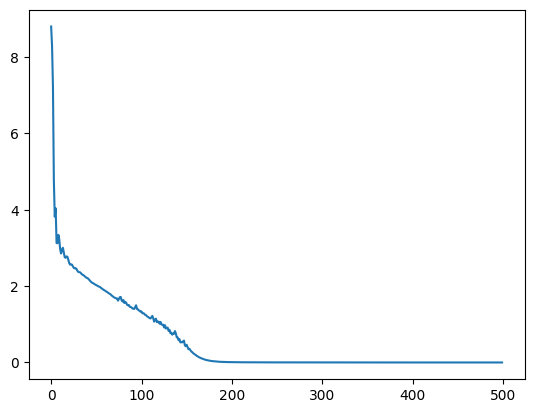

In [15]:
plt.plot(train_loss)

In [16]:
train_loss

[8.797950744628906,
 8.29289722442627,
 7.225500583648682,
 4.778061389923096,
 3.818382978439331,
 4.037731170654297,
 3.1267426013946533,
 3.121886968612671,
 3.341510534286499,
 3.2212696075439453,
 2.9611356258392334,
 2.853769540786743,
 2.9601147174835205,
 3.0039546489715576,
 2.884211301803589,
 2.7581100463867188,
 2.741041898727417,
 2.7779769897460938,
 2.7690937519073486,
 2.6926724910736084,
 2.6030521392822266,
 2.5624256134033203,
 2.568591833114624,
 2.564307928085327,
 2.5235464572906494,
 2.4778566360473633,
 2.465055227279663,
 2.470881938934326,
 2.449620485305786,
 2.40290904045105,
 2.370309591293335,
 2.3653581142425537,
 2.361539125442505,
 2.3388047218322754,
 2.3097083568573,
 2.2937586307525635,
 2.2820799350738525,
 2.2602622509002686,
 2.235989570617676,
 2.219076156616211,
 2.211838960647583,
 2.1951942443847656,
 2.1668851375579834,
 2.1377851963043213,
 2.114175319671631,
 2.094036817550659,
 2.081165313720703,
 2.0678422451019287,
 2.051201581954956,
 2